In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import ct_sm
from cosmoTransitions import pathDeformation
from cosmoTransitions import transitionFinder
%matplotlib inline
from collections import namedtuple
from collections import OrderedDict
import sys


def findTn(model, critobj, low_id, high_id, nucleationCrit=140.,makeMinPlot=False):
    """
    Now for a given parameter space point we can find the nucleation temperature by scanning around the relevant critical temperature
    and finding T_n such that S_3/T_n =140 (for the 3D case).
    
    Inputs:
        critobj: object containing the critical temperatures and vevs for a particular phase transition, 
        computed using model.calcTcTrans()
        nucleationCrit: Nucleation temperature is defined by S/T = nucleationCrit. 
    Returns:
        Tnuc: nucleation temperature
        S/T: value of the action at T=Tnuc. If Tnuc is physical, then S/T = nucleationCrit
    """
    # First, check that the transition is first order!
    if critobj['trantype']!=1:
        return -2,-2
    # A large number used to denome some kinds of error
    hugenum = 1e99
    #The critical temperature you want to start at 
    Tcrit = critobj['Tcrit']

    #The lowest temperature to consider; make sure it's higher than the temp where the high-T phase disappears
    highphase_id = high_id #critobj['high_phase']
    lowphase_id = low_id #critobj['low_phase']
    Tmin = model.phases[highphase_id].T[0]
    
    #The largest temperature to consider:
    Tmax = Tcrit-0.0001
    print "Tmin = ",Tmin, " Tmax = ", Tmax
    assert Tmin < Tmax
    #Tmax = transitionFinder._maxTCritForPhase(model.phases, model.phases[highphase_id])
    # Function that returns S/T for a given temperature T
    def actionFunction(T):
        V = lambda x: model.Vtot(x,T)
        gradV = lambda x: model.gradV(x,T)
        lowmin = scipy.optimize.fmin(V,model.phases[lowphase_id].valAt(T),disp=0,ftol=1e-8)
        print model.phases[highphase_id].valAt(T)
        highmin = scipy.optimize.fmin(V,[0.],disp=0,ftol=1e-8)
        #highmin = scipy.optimize.fmin(V,model.phases[highphase_id].valAt(T),disp=0,ftol=1e-8)
        # Make sure the minima are not the same
        mineps = np.linalg.norm(lowmin-highmin)/np.linalg.norm(lowmin+highmin)
        if mineps < 1e-2:
            return hugenum
        
    
        #assert V(lowmin) < V(highmin)
        if V(lowmin) > V(highmin):
            print "Vlow > Vhigh!"
            print "T = ", T
            print "dV = " ,V(lowmin)-V(highmin)
            print "low: ",lowmin, V(lowmin)
            print "high: ", highmin, V(highmin)
            return hugenum
        """
        t = np.linspace(-0.2,0.2,100)
        linphi = [highmin+ti*(lowmin-highmin) for ti in t]
        Vlin = [V(phii) for phii in linphi]
        plt.plot(t,Vlin)
        plt.ylim([-1e4,0])
        plt.show()
        hess_low = model.d2V(lowmin,T)
        hess_high = model.d2V(highmin,T)
        print lowmin, highmin
        print np.linalg.eigvals(hess_low), np.linalg.eigvals(hess_high)
        """
        path = [lowmin,highmin]
        tobj = pathDeformation.fullTunneling(path,V,gradV)
        return tobj.action/max(T,1e-5)-nucleationCrit
    
    # If S(T_min)/Tmin-140 > 0. then try to find the minimum action instead
    afMin = actionFunction(Tmin+1e-2)
    if (afMin > 0. and afMin < hugenum):
        TSmin =  scipy.optimize.fminbound(lambda T: np.fabs(actionFunction(T)),Tmin,Tmax,xtol=1e-3,maxfun=40)
        actFuncMin = actionFunction(TSmin)
        if (actFuncMin > 1.):
            print "Nucleation too slow! S/T > 140!"
            if makeMinPlot:
                Ts = np.linspace(Tmin,Tmax,num=20)
                SoT = [nucleationCrit+actionFunction(T) for T in Ts]
                plt.figure()
                plt.yscale('log')
                plt.plot(Ts,SoT,'b--',linewidth=3.0)
                plt.show()
        
            Tnuc = 1e99
            return Tnuc, actFuncMin+nucleationCrit
    # The pair of minima provided in critobj were not good
    elif afMin == hugenum:
        return -1, -1
        
    # Otherwise find the proper nucleation temperature
    else:
        # Make sure the root is bracketed
        aTmax = actionFunction(Tmax-1e-2)
        aTmin = actionFunction(Tmin+1e-2)
        assert aTmax > 0. and aTmin < 0.
        Tnuc = scipy.optimize.brentq(actionFunction,Tmin+1e-2,Tmax,xtol=1e-5)

    
    print "Tnuc = ",Tnuc #, " actionFunction = ", actionFunction(Tnuc)
    return Tnuc, actionFunction(Tnuc)+nucleationCrit

def calcStrength(critobj):
    if critobj['trantype']==1:
        return np.linalg.norm(critobj['low_vev'])/critobj['Tcrit']
    else:
        return 0




##Phase Transition with all modes resummed

In [2]:
model = ct_sm.sm_eft()

Guesses for mu12 and l1 =  -7849.96 0.11
RG running with initial parameters at the input scale...
Finding the correct parameters at the input scale...
Iteration converged with [mu12, lam1] =  [-8651.6786477617497, 0.14903947069623535]
v, mh =  [ 246.22001648] 125.000531249
Final values of mu12, l1 =  -8943.57161006 0.125846591177
Scale set at mu =  246.22
vev =  [ 246.22001648]
mh =  125.000132812


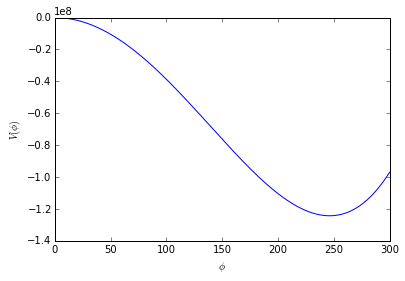

In [3]:
model.plot1d(0,300,T=0)

In [4]:
scipy.optimize.minimize(lambda x: model.Vtot(x,T=0),[200],method='Nelder-Mead')

 final_simplex: (array([[ 246.22001648],
       [ 246.21994019]]), array([ -1.26031720e+08,  -1.26031720e+08]))
           fun: -126031719.92768452
       message: 'Optimization terminated successfully.'
          nfev: 42
           nit: 21
        status: 0
       success: True
             x: array([ 246.22001648])

In [5]:
np.sqrt(model.d2V(model.findMinimum(),T=0))

array([[ 124.9995]])

Tracing phase starting at x = [ 246.21998952] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.....................................................................................................................................................................
Tracing phase starting at x = [  8.67361738e-19] ; t = 159.73957204
Tracing minimum down
traceMinimum t0 = 159.74
..........................
Tracing minimum up
traceMinimum t0 = 159.74
..........


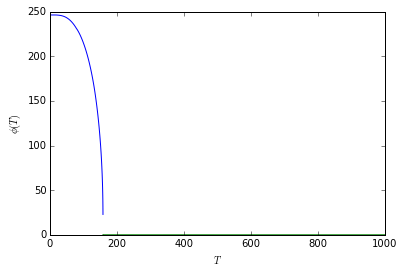

In [6]:
model.plotPhasesPhi()

In [7]:
model.phases

{0: Phase(key=0, X=[[246.2], ..., [22.81]], T=[0, ..., 158.7], dXdT=[[-1.945e-19], ..., [-207]],
 1: Phase(key=1, X=[[-0.02063], ..., [0.004039]], T=[158.6, ..., 1000], dXdT=[[6.176], ..., [-0.001272]]}

In [8]:
transObj=model.calcTcTrans()
Tc = transObj[0]['Tcrit']
transObj

[{'Delta_rho': 5155772.2223072052,
  'Tcrit': 158.6883899871672,
  'high_phase': 1,
  'high_vev': array([-0.00260454]),
  'low_phase': 0,
  'low_vev': array([ 26.87059601]),
  'trantype': 1}]

In [9]:
calcStrength(transObj[0])

0.16932931268107235

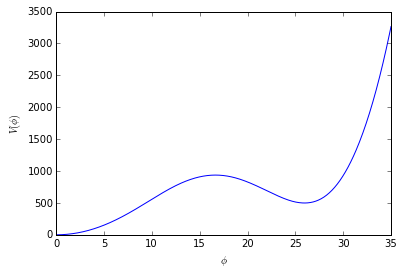

In [10]:
model.plot1d(0,35,T=Tc*1.0001)

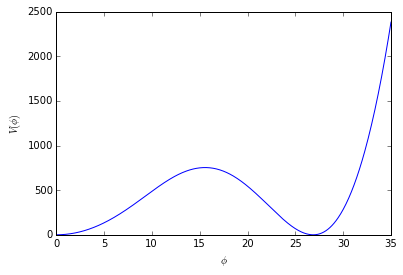

In [11]:
model.plot1d(0,35,T=Tc)

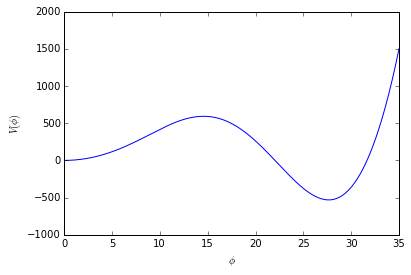

In [12]:
model.plot1d(0,35,T=Tc*0.9999)

In [13]:
# Dumb function works!
findTn(model,transObj[0],0,1)

Tmin =  158.559054616  Tmax =  158.688289987
[-0.00900025]
Path deformation converged. 1 steps. fRatio = 6.77984e-14
[-0.0042683]
Path deformation converged. 1 steps. fRatio = 1.62189e-13
[-0.00900025]
Path deformation converged. 1 steps. fRatio = 6.77984e-14
[-0.00900025]
Path deformation converged. 1 steps. fRatio = 6.77984e-14
[-0.00261875]
Path deformation converged. 1 steps. fRatio = 2.64388e-13
[-0.00903081]
Path deformation converged. 1 steps. fRatio = 6.76152e-14
[-0.01567473]
Path deformation converged. 1 steps. fRatio = 1.53752e-13
[-0.00874589]
Path deformation converged. 1 steps. fRatio = 1.25676e-13
[-0.00524811]
Path deformation converged. 1 steps. fRatio = 1.60824e-13
[-0.005695]
Path deformation converged. 1 steps. fRatio = 8.01332e-14
[-0.00545744]
Path deformation converged. 1 steps. fRatio = 1.28447e-13
[-0.00543685]
Path deformation converged. 1 steps. fRatio = 1.92701e-13
[-0.0054347]
Path deformation converged. 1 steps. fRatio = 1.28469e-13
Tnuc =  158.672517274
[

cosmoTransitions/tunneling1D.py:407: RuntimeWarning: overflow encountered in double_scalars
  r *= 10


(158.67251727403422, 140.02787221245629)

##Phase Transition with only 0 modes resummed

In [2]:
model = ct_sm.sm_eft()
model.daisyResum = 2

Guesses for mu12 and l1 =  -7849.96 0.11
RG running with initial parameters at the input scale...
Finding the correct parameters at the input scale...
Iteration converged with [mu12, lam1] =  [-8651.6786477617497, 0.14903947069623535]
v, mh =  [ 246.22001648] 125.000531249
Final values of mu12, l1 =  -8943.57161006 0.125846591177
Scale set at mu =  246.22
vev =  [ 246.22001648]
mh =  125.000132812


In [17]:
model.getPhases(tracingArgs={"single_trace_args": {"minratio": 1e-5}})

Tracing phase starting at x = [ 246.21998952] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
...............................................................
Tracing phase starting at x = [ 237.30746897] ; t = 74.2752928407
Tracing minimum down
traceMinimum t0 = 74.2753
......................
Tracing minimum up
traceMinimum t0 = 74.2753
........................................................................................................................................................................................................................................................................................................................................
Tracing phase starting at x = [ -6.12439371e-06] ; t = 174.889632328
Tracing minimum down
traceMinimum t0 = 174.89
........................................
Tracing minimum up
traceMinimum t0 = 174.89
.............


{0: Phase(key=0, X=[[246.2], ..., [237.5]], T=[0, ..., 73.27], dXdT=[[-1.945e-19], ..., [-0.6143]],
 1: Phase(key=1, X=[[237.6], ..., [20.86]], T=[73.26, ..., 173.9], dXdT=[[0.08328], ..., [-1176]],
 2: Phase(key=2, X=[[0.0067], ..., [-4.857e-17]], T=[173.9, ..., 1000], dXdT=[[-1.723], ..., [0.0009196]]}

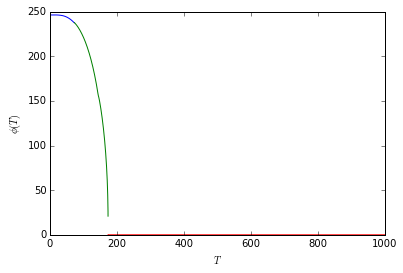

In [15]:
model.plotPhasesPhi()

In [4]:
model.phases

{0: Phase(key=0, X=[[246.2], ..., [237.5]], T=[0, ..., 73.27], dXdT=[[-1.945e-19], ..., [-0.6143]],
 1: Phase(key=1, X=[[237.6], ..., [20.86]], T=[73.26, ..., 173.9], dXdT=[[0.08328], ..., [-1176]],
 2: Phase(key=2, X=[[0.0067], ..., [-4.857e-17]], T=[173.9, ..., 1000], dXdT=[[-1.723], ..., [0.0009196]]}

Note that there is no phase overlap! So no first order transition

In [33]:
model.phases[2].T[0]

173.9139501393222

In [35]:
model.phases[1].T[-1]

173.88944263448789

In [36]:
transObj=model.calcTcTrans()
Tc = transObj[0]['Tcrit']
transObj

[{'Delta_rho': 0.0,
  'Tcrit': 173.90169638690503,
  'action': 0.0,
  'high_phase': 2,
  'high_vev': array([ 0.00670028]),
  'instanton': None,
  'low_phase': 1,
  'low_vev': array([ 0.00670028]),
  'trantype': 2},
 {'Delta_rho': -15939.181071996689,
  'Tcrit': 73.26915853539649,
  'high_phase': 1,
  'high_vev': array([ 237.60225544]),
  'low_phase': 0,
  'low_vev': array([ 237.45419823]),
  'trantype': 1}]

In [9]:
calcStrength(transObj[0])

0

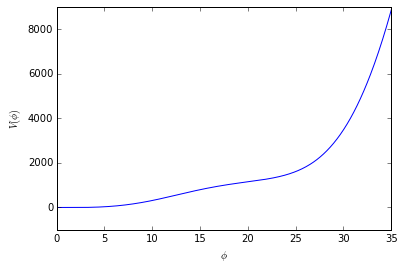

In [10]:
model.plot1d(0,35,T=Tc*1.0001)

Minima are so shallow that it is difficult to see by eye if there is phase coexistence

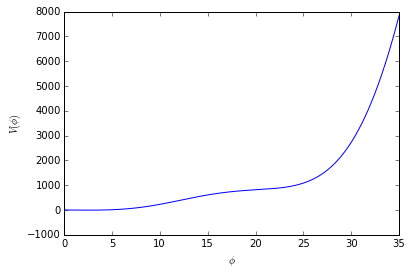

In [11]:
model.plot1d(0,35,T=Tc)

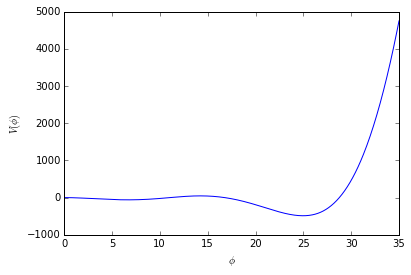

In [37]:
model.plot1d(0,35,T=Tc*0.9997)

##No Daisy Resummation

In [11]:
model = ct_sm.sm_eft()
model.daisyResum = 0

Guesses for mu12 and l1 =  -7849.96 0.11
RG running with initial parameters at the input scale...
Finding the correct parameters at the input scale...
Iteration converged with [mu12, lam1] =  [-8651.6786477617497, 0.14903947069623535]
v, mh =  [ 246.22001648] 125.000531249
Final values of mu12, l1 =  -8943.57161006 0.125846591177
Scale set at mu =  246.22
vev =  [ 246.22001648]
mh =  125.000132812


Tracing phase starting at x = [ 246.21998952] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.......................................................................................................................................................................
Tracing phase starting at x = [ 152.93027006] ; t = 132.875996681
Tracing minimum down
traceMinimum t0 = 132.876
.....................
Tracing minimum up
traceMinimum t0 = 132.876
.......................................................................................................................................................................................................................................................................
Tracing phase starting at x = [ -4.98437500e-05] ; t = 157.211430833
Tracing minimum down
traceMinimum t0 = 157.211
.............................
Tracing minimum up
traceMinimum t0 = 157.211
...............


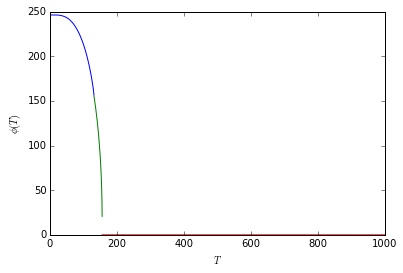

In [12]:
model.plotPhasesPhi()

In [13]:
model.phases

{0: Phase(key=0, X=[[246.2], ..., [156.4]], T=[0, ..., 131.9], dXdT=[[-1.945e-19], ..., [-6.156]],
 1: Phase(key=1, X=[[155.4], ..., [20.65]], T=[131.9, ..., 156.2], dXdT=[[-1.581], ..., [-544.8]],
 2: Phase(key=2, X=[[0.0008872], ..., [-5.551e-17]], T=[156.1, ..., 1000], dXdT=[[5.534], ..., [0.0007549]]}

In [14]:
transObj=model.calcTcTrans()
Tc = transObj[0]['Tcrit']
transObj

[{'Delta_rho': 3774072.5476417542,
  'Tcrit': 156.16439975824136,
  'high_phase': 2,
  'high_vev': array([-0.0058435]),
  'low_phase': 1,
  'low_vev': array([ 25.0236997]),
  'trantype': 1},
 {'Delta_rho': 0.0,
  'Tcrit': 131.87493275749796,
  'action': 0.0,
  'high_phase': 1,
  'high_vev': array([ 155.38770728]),
  'instanton': None,
  'low_phase': 0,
  'low_vev': array([ 155.38770728]),
  'trantype': 2}]

In [15]:
calcStrength(transObj[0])

0.16023946389333849

##Daisy Resummation Comparison

In [38]:
model = ct_sm.sm_eft()

Guesses for mu12 and l1 =  -7849.96 0.11
RG running with initial parameters at the input scale...
Finding the correct parameters at the input scale...
Iteration converged with [mu12, lam1] =  [-8651.6786477617497, 0.14903947069623535]
v, mh =  [ 246.22001648] 125.000531249
Final values of mu12, l1 =  -8943.57161006 0.125846591177
Scale set at mu =  246.22
vev =  [ 246.22001648]
mh =  125.000132812


In [60]:
v1 = 0
v2 = 300
Tc = 158.6883899871672


v = np.linspace(v1,v2,100)[:,np.newaxis]
model.daisyResum = 0
VT50_d0 = model.DVtot(v,50.)
VTTc_d0 = model.DVtot(v,Tc)
VT200_d0 = model.DVtot(v,200.)

model.daisyResum = 1
VT50_d1 = model.DVtot(v,50.)
VTTc_d1 = model.DVtot(v,Tc)
VT200_d1 = model.DVtot(v,200.)

model.daisyResum = 2
VT50_d2 = model.DVtot(v,50.)
VTTc_d2 = model.DVtot(v,Tc)
VT200_d2 = model.DVtot(v,200.)

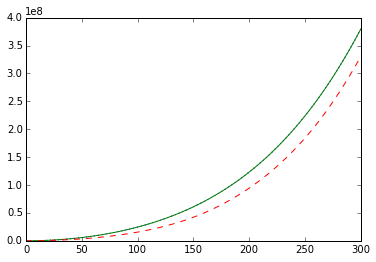

In [61]:
plt.plot(v,VT200_d1,':',v,VT200_d1,v,VT200_d2,'--')

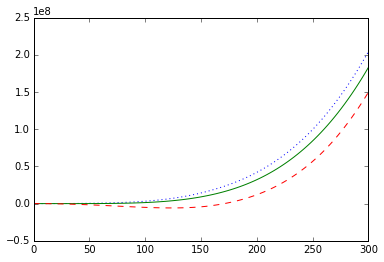

In [62]:
plt.plot(v,VTTc_d0,':',v,VTTc_d1,v,VTTc_d2,'--')